In [1]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_score
from sklearn.metrics import confusion_matrix , accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt 

import warnings

warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

In [2]:
df=pd.read_csv('./titanic_temizlenmiş.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
y=df['Survived']
x=df.drop(['Survived'],axis=1)

In [4]:
x_train ,x_test ,y_train ,y_test =train_test_split(x,
                                                   y,
                                                   test_size=0.3,
                                                   random_state=42,stratify=y)

# StandarScaler

In [5]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
scaler.fit(x_test)
x_test_scaled=scaler.transform(x_test)

# Logistic Regression

In [58]:
loj_model=LogisticRegression()
loj_params={'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
loj_cv_model=GridSearchCV(loj_model,loj_params,cv=10).fit(x_train_scaled,y_train)

In [59]:
#Burda en iyi methodumuz newton-cg 
loj_cv_model.best_params_

{'solver': 'newton-cg'}

In [60]:
#Final model
loj_final=LogisticRegression(solver=loj_cv_model.best_params_['solver']).fit(x_train_scaled,y_train)

In [113]:
#Train ve test arasında neredeyse hiç fark yok 
#Karmaşıklık matrisinde ise doğru tahmin edilmesi gerekenler çoguntukta duruyor sorun yok gibi duruyor
y_pred_test=loj_final.predict(x_test_scaled)
y_pred_train=loj_final.predict(x_train_scaled)

loj_accuracy_test=accuracy_score(y_test,y_pred_test)
loj_accuracy_train=accuracy_score(y_train,y_pred_train)

print('Test sonucu',loj_accuracy_test)
print('Eğitim sonucu',loj_accuracy_train)
print(confusion_matrix(y_test,y_pred_test))
#Aşagıdaki hata değerleri arasında da çok fazla fark olmadığı için sorun yok diyebiliriz
print('K katlı test sonucu',cross_val_score(loj_final,x_test_scaled,y_test,cv=15).mean())
print('K katlı eğitim sonucu',cross_val_score(loj_final,x_train_scaled,y_train,cv=15).mean())



Test sonucu 0.8052434456928839
Eğitim sonucu 0.8132045088566827
[[143  22]
 [ 30  72]]
K katlı test sonucu 0.7904139433551199
K katlı eğitim sonucu 0.8005807200929153


# Random Forest Classifier

In [81]:
rf=RandomForestClassifier()
rf_params={
    'n_estimators':[500,600,1000,1500],
    'max_features':[6,7,8],
    'min_samples_split':[2,3,4]
    }
rf_cv_model=GridSearchCV(rf, rf_params,cv=10).fit(x_train,y_train)


In [82]:
print(rf_cv_model.best_params_)

{'max_features': 7, 'min_samples_split': 4, 'n_estimators': 500}


In [83]:
rf_tuned=RandomForestClassifier(n_estimators=rf_cv_model.best_params_['n_estimators'],
                                max_features=rf_cv_model.best_params_['max_features'],
                                min_samples_split=rf_cv_model.best_params_['min_samples_split']
                                ).fit(x_train, y_train)

In [84]:
y_pred_test=rf_tuned.predict(x_test)
y_pred_train=rf_tuned.predict(x_train)

rf_accuracy_test=accuracy_score(y_test, y_pred_test)
rf_accuracy_train=accuracy_score(y_train, y_pred_train)
print('Test skoru :',rf_accuracy_test)
print('Train skoru :',rf_accuracy_train)

print('K katlı test skoru',cross_val_score(rf_tuned,x_test,y_test,cv=15).mean())
print('K katlı eğitim skoru',cross_val_score(rf_tuned,x_train,y_train,cv=15).mean())



Test skoru : 0.8277153558052435
Train skoru : 0.9565217391304348
K katlı test skoru 0.8058823529411766
K katlı eğitim skoru 0.8134339914827721


Yukarıdaki sonuçlara baktığımda modelin overfit olduğunu düşünüyorum çünkü train ve test sonuçları birbirinden uzak 
bunu engellemek için ilk önce ağacın budanmasını azaltmak istedim fakat budama yöntemi de overfiti azaltmak için olduğundan daha kötü sonuçlar elde ettim.
Daha sonra ise GridSearchCV fonksiyonundan aldığım optimum parametre değerlerini optimum olmayanlarla değiştirdim fakat sonuç tekrar daha kötü hale geldi.
En sonunda ise madem ağacım çok iyi ögreniyor bende ağacı yarıdayken keseyim yani max_depth parametresini düşük bir değer vereyim dedim.Bunu yaptıktan sonra test ve train sonuçları gerçekten birbirine daha çok yaklaştı.İnternette'de yaptığım araştırmalar sonucunda max_depth in yüksek olmasının düşük bias yüksek varyansa,düşük olması ise yüksek bias düşük varyansa sebep oluyormuş.Ortasını bulacağız.

# Optimum max_depth için inceleme

In [111]:
test_scores=[]
train_scores=[]

for i in range(1,10):
    rf_tuned=RandomForestClassifier(n_estimators=rf_cv_model.best_params_['n_estimators'],
                                max_features=rf_cv_model.best_params_['max_features'],
                                min_samples_split=rf_cv_model.best_params_['min_samples_split'],
                                max_depth=i
                                ).fit(x_train, y_train)
    test_pred=rf_tuned.predict(x_test)
    test_acc=accuracy_score(y_test,test_pred)
    test_scores.append(test_acc)
    print(i,'iterasyon için test sonucu :',test_acc)
    
    train_pred=rf_tuned.predict(x_train)
    train_acc=accuracy_score(y_train,train_pred)
    train_scores.append(train_acc)
    print(i,'iterasyon için train sonucu :',train_acc)
    print('*********************************')

    

1 iterasyon için test sonucu : 0.7790262172284644
1 iterasyon için train sonucu : 0.7922705314009661
*********************************
2 iterasyon için test sonucu : 0.7715355805243446
2 iterasyon için train sonucu : 0.8051529790660226
*********************************
3 iterasyon için test sonucu : 0.7790262172284644
3 iterasyon için train sonucu : 0.8148148148148148
*********************************
4 iterasyon için test sonucu : 0.8089887640449438
4 iterasyon için train sonucu : 0.8454106280193237
*********************************
5 iterasyon için test sonucu : 0.8014981273408239
5 iterasyon için train sonucu : 0.8647342995169082
*********************************
6 iterasyon için test sonucu : 0.8014981273408239
6 iterasyon için train sonucu : 0.8904991948470209
*********************************
7 iterasyon için test sonucu : 0.8164794007490637
7 iterasyon için train sonucu : 0.9066022544283414
*********************************
8 iterasyon için test sonucu : 0.8239700374531835
8 ite

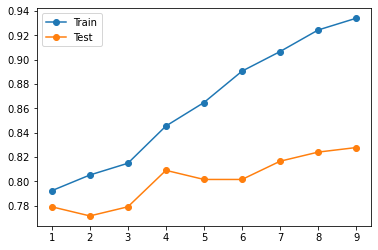

In [112]:
plt.plot(range(1,10), train_scores, '-o', label='Train')
plt.plot(range(1,10), test_scores, '-o', label='Test')
plt.legend()
plt.show()

Yukarıda max_depth 1 ve 4 için daha öncekine nazaran daha iyi sonuçlar elde ettik.
Son olarak max_features'ı da küçülterek ağaç boyunu kısaltmaya ve grafikteki eğrileri biraz daha yakınlaştırıp 
güzel bir max_depth ve max_features ikilisi yakalamaya çalışacağım

# En uygun max_depth ve max_features ikilisini yakalamaya çalışmak

max_depth  1 ve max _features  1  iterasyon için test sonucu : 0.6217228464419475
max_depth  1 ve max _features  1  iterasyon için train sonucu : 0.6215780998389694
******************************************************************************
max_depth  1 ve max _features  2  iterasyon için test sonucu : 0.7228464419475655
max_depth  1 ve max _features  2  iterasyon için train sonucu : 0.7246376811594203
******************************************************************************
max_depth  1 ve max _features  3  iterasyon için test sonucu : 0.7378277153558053
max_depth  1 ve max _features  3  iterasyon için train sonucu : 0.750402576489533
******************************************************************************
max_depth  1 ve max _features  4  iterasyon için test sonucu : 0.7715355805243446
max_depth  1 ve max _features  4  iterasyon için train sonucu : 0.7681159420289855
******************************************************************************
max_depth  1 ve max _feat

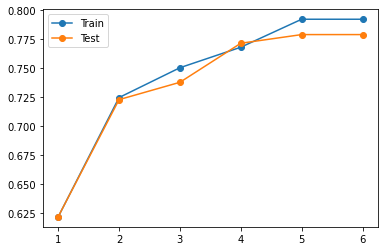

max_depth  2 ve max _features  1  iterasyon için test sonucu : 0.7528089887640449
max_depth  2 ve max _features  1  iterasyon için train sonucu : 0.7552334943639292
******************************************************************************
max_depth  2 ve max _features  2  iterasyon için test sonucu : 0.7640449438202247
max_depth  2 ve max _features  2  iterasyon için train sonucu : 0.7713365539452496
******************************************************************************
max_depth  2 ve max _features  3  iterasyon için test sonucu : 0.7865168539325843
max_depth  2 ve max _features  3  iterasyon için train sonucu : 0.7987117552334944
******************************************************************************
max_depth  2 ve max _features  4  iterasyon için test sonucu : 0.7790262172284644
max_depth  2 ve max _features  4  iterasyon için train sonucu : 0.7938808373590982
******************************************************************************
max_depth  2 ve max _fea

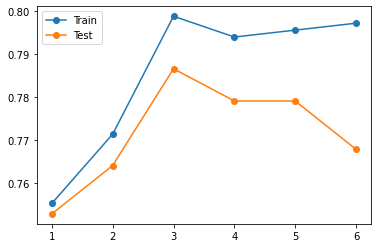

max_depth  3 ve max _features  1  iterasyon için test sonucu : 0.8014981273408239
max_depth  3 ve max _features  1  iterasyon için train sonucu : 0.7906602254428341
******************************************************************************
max_depth  3 ve max _features  2  iterasyon için test sonucu : 0.8239700374531835
max_depth  3 ve max _features  2  iterasyon için train sonucu : 0.8357487922705314
******************************************************************************
max_depth  3 ve max _features  3  iterasyon için test sonucu : 0.8052434456928839
max_depth  3 ve max _features  3  iterasyon için train sonucu : 0.822866344605475
******************************************************************************
max_depth  3 ve max _features  4  iterasyon için test sonucu : 0.7902621722846442
max_depth  3 ve max _features  4  iterasyon için train sonucu : 0.8164251207729468
******************************************************************************
max_depth  3 ve max _feat

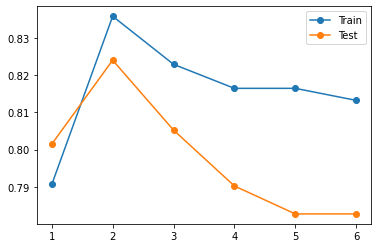

max_depth  4 ve max _features  1  iterasyon için test sonucu : 0.8014981273408239
max_depth  4 ve max _features  1  iterasyon için train sonucu : 0.8470209339774557
******************************************************************************
max_depth  4 ve max _features  2  iterasyon için test sonucu : 0.8389513108614233
max_depth  4 ve max _features  2  iterasyon için train sonucu : 0.8470209339774557
******************************************************************************
max_depth  4 ve max _features  3  iterasyon için test sonucu : 0.8239700374531835
max_depth  4 ve max _features  3  iterasyon için train sonucu : 0.8325281803542673
******************************************************************************
max_depth  4 ve max _features  4  iterasyon için test sonucu : 0.8052434456928839
max_depth  4 ve max _features  4  iterasyon için train sonucu : 0.8293075684380032
******************************************************************************
max_depth  4 ve max _fea

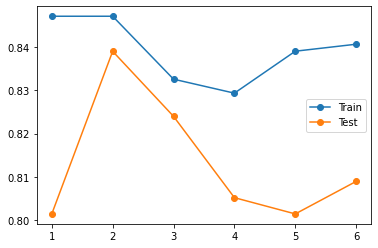

max_depth  5 ve max _features  1  iterasyon için test sonucu : 0.8164794007490637
max_depth  5 ve max _features  1  iterasyon için train sonucu : 0.855072463768116
******************************************************************************
max_depth  5 ve max _features  2  iterasyon için test sonucu : 0.8352059925093633
max_depth  5 ve max _features  2  iterasyon için train sonucu : 0.8647342995169082
******************************************************************************
max_depth  5 ve max _features  3  iterasyon için test sonucu : 0.8352059925093633
max_depth  5 ve max _features  3  iterasyon için train sonucu : 0.8582930756843801
******************************************************************************
max_depth  5 ve max _features  4  iterasyon için test sonucu : 0.8052434456928839
max_depth  5 ve max _features  4  iterasyon için train sonucu : 0.8615136876006442
******************************************************************************
max_depth  5 ve max _feat

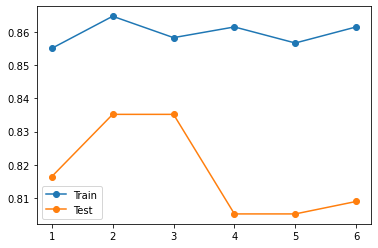

max_depth  6 ve max _features  1  iterasyon için test sonucu : 0.8164794007490637
max_depth  6 ve max _features  1  iterasyon için train sonucu : 0.8711755233494364
******************************************************************************
max_depth  6 ve max _features  2  iterasyon için test sonucu : 0.8239700374531835
max_depth  6 ve max _features  2  iterasyon için train sonucu : 0.8743961352657005
******************************************************************************
max_depth  6 ve max _features  3  iterasyon için test sonucu : 0.8089887640449438
max_depth  6 ve max _features  3  iterasyon için train sonucu : 0.8776167471819646
******************************************************************************
max_depth  6 ve max _features  4  iterasyon için test sonucu : 0.8014981273408239
max_depth  6 ve max _features  4  iterasyon için train sonucu : 0.8856682769726248
******************************************************************************
max_depth  6 ve max _fea

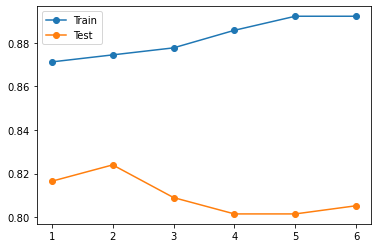

max_depth  7 ve max _features  1  iterasyon için test sonucu : 0.8164794007490637
max_depth  7 ve max _features  1  iterasyon için train sonucu : 0.8872785829307569
******************************************************************************
max_depth  7 ve max _features  2  iterasyon için test sonucu : 0.8239700374531835
max_depth  7 ve max _features  2  iterasyon için train sonucu : 0.9033816425120773
******************************************************************************
max_depth  7 ve max _features  3  iterasyon için test sonucu : 0.8239700374531835
max_depth  7 ve max _features  3  iterasyon için train sonucu : 0.9066022544283414
******************************************************************************
max_depth  7 ve max _features  4  iterasyon için test sonucu : 0.8239700374531835
max_depth  7 ve max _features  4  iterasyon için train sonucu : 0.9001610305958132
******************************************************************************
max_depth  7 ve max _fea

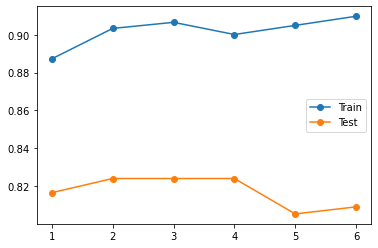

max_depth  8 ve max _features  1  iterasyon için test sonucu : 0.8164794007490637
max_depth  8 ve max _features  1  iterasyon için train sonucu : 0.9001610305958132
******************************************************************************
max_depth  8 ve max _features  2  iterasyon için test sonucu : 0.8277153558052435
max_depth  8 ve max _features  2  iterasyon için train sonucu : 0.9049919484702094
******************************************************************************
max_depth  8 ve max _features  3  iterasyon için test sonucu : 0.8202247191011236
max_depth  8 ve max _features  3  iterasyon için train sonucu : 0.9162640901771336
******************************************************************************
max_depth  8 ve max _features  4  iterasyon için test sonucu : 0.8202247191011236
max_depth  8 ve max _features  4  iterasyon için train sonucu : 0.9130434782608695
******************************************************************************
max_depth  8 ve max _fea

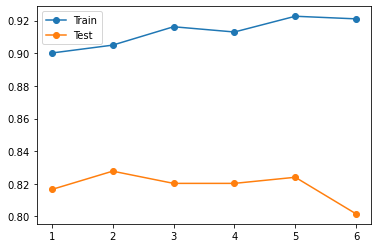

max_depth  9 ve max _features  1  iterasyon için test sonucu : 0.8239700374531835
max_depth  9 ve max _features  1  iterasyon için train sonucu : 0.9178743961352657
******************************************************************************
max_depth  9 ve max _features  2  iterasyon için test sonucu : 0.8314606741573034
max_depth  9 ve max _features  2  iterasyon için train sonucu : 0.9210950080515298
******************************************************************************
max_depth  9 ve max _features  3  iterasyon için test sonucu : 0.8352059925093633
max_depth  9 ve max _features  3  iterasyon için train sonucu : 0.9210950080515298
******************************************************************************
max_depth  9 ve max _features  4  iterasyon için test sonucu : 0.8314606741573034
max_depth  9 ve max _features  4  iterasyon için train sonucu : 0.9307568438003221
******************************************************************************
max_depth  9 ve max _fea

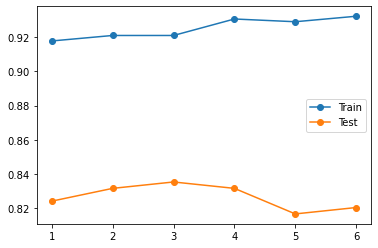

In [126]:

for i in range(1,10):
    test_scores=[]
    train_scores=[]
    for j in range(1,7):
        rf_tuned=RandomForestClassifier(n_estimators=rf_cv_model.best_params_['n_estimators'],
                                max_features=j,
                                min_samples_split=rf_cv_model.best_params_['min_samples_split'],
                                max_depth=i
                                ).fit(x_train, y_train)
        
        test_pred=rf_tuned.predict(x_test)
        test_acc=accuracy_score(y_test,test_pred)
        test_scores.append(test_acc)
        print('max_depth ',i,'ve max _features ',j,' iterasyon için test sonucu :',test_acc)
        
        train_pred=rf_tuned.predict(x_train)
        train_acc=accuracy_score(y_train,train_pred)
        train_scores.append(train_acc)
        print('max_depth ',i,'ve max _features ',j,' iterasyon için train sonucu :',train_acc)
        print('******************************************************************************')
    plt.plot(range(1,7), train_scores, '-o', label='Train')
    plt.plot(range(1,7), test_scores, '-o', label='Test')
    plt.legend()
    plt.show()

Sonuç olarak hem test sonucunun yüksek olması için ve test ve train arasında fazla fark olmaması için max_depth 4 ve max_features=2 olan ikiliyi seçiyorum

# XGBoost

In [9]:
from xgboost import XGBClassifier

In [10]:
xgb=XGBClassifier()
xgb_params={
        'n_estimators':[200,500,600],
        'subsample':[0.6,0.8],
        'max_depth':[5,7]    }
xgb_cv_model=GridSearchCV(xgb, xgb_params,cv=10).fit(x_train,y_train)

In [11]:
print(xgb_cv_model.best_params_)

{'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}


In [12]:
xgb_tuned=XGBClassifier(subsample=xgb_cv_model.best_params_['subsample'],
                        n_estimators=xgb_cv_model.best_params_['n_estimators'],
                        max_depth=xgb_cv_model.best_params_['max_depth'],
                        ).fit(x_train,y_train)

In [13]:
y_pred_test=xgb_tuned.predict(x_test)
y_pred_train=xgb_tuned.predict(x_train)

xgb_accuracy_test=accuracy_score(y_test, y_pred_test)
xgb_accuracy_train=accuracy_score(y_train, y_pred_train)
print('Test skoru :',xgb_accuracy_test)
print('Train skoru :',xgb_accuracy_train)

print('K katlı test skoru',cross_val_score(xgb_tuned,x_test,y_test,cv=15).mean())
print('K katlı eğitim skoru',cross_val_score(xgb_tuned,x_train,y_train,cv=15).mean())


Test skoru : 0.7940074906367042
Train skoru : 0.9790660225442834
K katlı test skoru 0.8017429193899783
K katlı eğitim skoru 0.7684862562911344


In [14]:
xgb=XGBClassifier()

xgb_params={
        'n_estimators':[200,500,600],
        'subsample':[0.6,0.8],
        'min_split_loss':[1,2,3],
        'learning_rate':[0.1,0.01]
}
xgb_cv_model=GridSearchCV(xgb, xgb_params,cv=10).fit(x_train,y_train)
    

In [15]:
print(xgb_cv_model.best_params_)

{'learning_rate': 0.01, 'min_split_loss': 1, 'n_estimators': 600, 'subsample': 0.8}


In [28]:
xgb_tuned=XGBClassifier(subsample=xgb_cv_model.best_params_['subsample'],
                        n_estimators=xgb_cv_model.best_params_['n_estimators'],
                        max_depth=7,
                        min_split_loss=3,
                        learning_rate=0.1
                       ).fit(x_train,y_train)

In [29]:
y_pred_test=xgb_tuned.predict(x_test)
y_pred_train=xgb_tuned.predict(x_train)

xgb_accuracy_test=accuracy_score(y_test, y_pred_test)
xgb_accuracy_train=accuracy_score(y_train, y_pred_train)
print('Test skoru :',xgb_accuracy_test)
print('Train skoru :',xgb_accuracy_train)

print('K katlı test skoru',cross_val_score(xgb_tuned,x_test,y_test,cv=15).mean())
print('K katlı eğitim skoru',cross_val_score(xgb_tuned,x_train,y_train,cv=15).mean())


Test skoru : 0.8352059925093633
Train skoru : 0.895330112721417
K katlı test skoru 0.7976034858387799
K katlı eğitim skoru 0.8135501355013551
